## 导入必要的模块

In [12]:
import pandas as pd
import sklearn
import random
import time
import scipy as sp
import sklearn.metrics as met
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import random_sample
from math import sqrt, log
%matplotlib inline

## 导入我自定义的一些函数

In [2]:
from arsena import *

## Read data 
* data_Tab2: power data, pandas.DataFrame
* holidayData, holidayData_Part: 
* weather: outdoor air temperature (max,min)

In [3]:
data = pd.read_csv(r'.\Tianchi_power\Tianchi_power.csv',parse_dates = [0],
                   dtype = {'power_consumption': np.int16, 'user_id': np.int16},
                  encoding = 'gbk')
# fill missing value with 0
data_Tab =data.pivot_table(values = 'power_consumption',index = 'record_date',
                           columns = 'user_id',fill_value = 0)
data_Tab2 = data_Tab.transpose()


holidayData = pd.read_csv(r'date.csv')
weather = pd.read_csv(r'yangzhong_weather.csv')
holidayData_Part = holidayData.iloc[:639,:]

In [4]:
data_Tab2.to_csv('data_Tab2.csv')

## Clean Data
1. replace outliers by interpolating, but what if a user has a lot of densely distributed outliers?
   * Solution 1: delete all outliers, and replace with average value
   * Solution 2: Use a surrogagte user, which is selected from the rest users..

In [5]:
missingValue_Idx = data_Tab2 < 0
missingValue_Idx.sum(axis = 1).sort_values(ascending = False)

user_id
1416    337
1262    318
90      305
174     299
175     260
1310    243
1307    243
129     229
1124    224
275     204
1112     36
1181     26
768       7
1350      5
514       3
1161      2
1346      1
481       0
485       0
482       0
483       0
480       0
484       0
1454      0
486       0
487       0
488       0
479       0
490       0
491       0
       ... 
985       0
986       0
987       0
988       0
989       0
990       0
991       0
972       0
971       0
970       0
959       0
951       0
952       0
953       0
954       0
955       0
956       0
957       0
958       0
960       0
969       0
961       0
962       0
963       0
964       0
965       0
966       0
967       0
968       0
1         0
dtype: int64

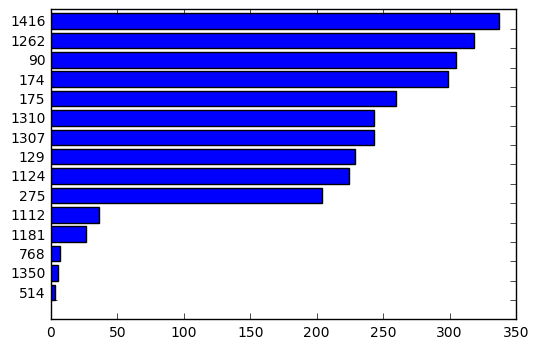

In [6]:
ax = plt.subplot(1,1,1)
plt.barh(np.arange(15,0,-1),missingValue_Idx.sum(axis = 1).sort_values(ascending = False)[:15])
ax.set_yticks(np.arange(15,0,-1))
ax.set_yticklabels(missingValue_Idx.sum(axis = 1).sort_values(ascending = False).index[:15],verticalalignment = 'bottom');

In [8]:
data_Filled = data_Tab2.copy()
data_Filled[missingValue_Idx] = np.float('nan')
data_Filled = data_Filled.fillna(axis = 1, method = 'bfill').fillna(axis = 1, method = 'ffill')

## Clustering
    * Clustering directly, why should I implement a clustering operation?

In [9]:
kmeansMiner = KMeans(n_clusters=4, random_state=0)
s = kmeansMiner.fit(data_Filled)

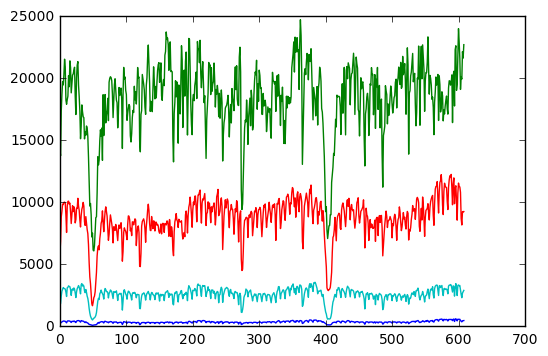

In [10]:
plt.plot(np.transpose(s.cluster_centers_));

In [234]:
kmeansMiner = KMeans(n_clusters=3, random_state=0)
kmeansMiner.fit(data_Tab2)
k_max = 20
(gaps,sks,wks) = gap_statistic(data_Tab2,k_max)

### result visualization

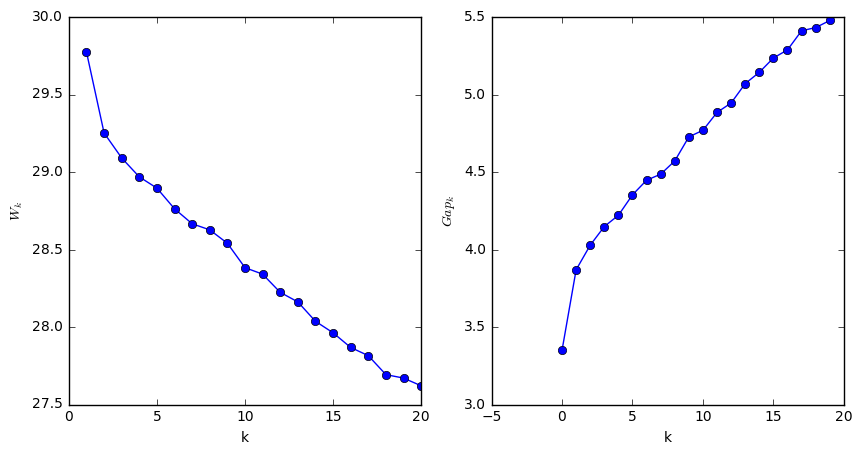

In [235]:
plt.figure(figsize = [10,5])
ax = plt.subplot(1,2,1)
plt.plot(wks,'-o')
ax.set_xlabel('k')
ax.set_ylabel('$W_k$')

ax = plt.subplot(1,2,2)
plot_gaps(gaps,sks)
ax.set_xlabel('k')
ax.set_ylabel('$Gap_k$')

## Predict using Facebook's Prophet

In [11]:
from fbprophet import Prophet

In [14]:
holidays = holidayData.join(pd.DataFrame(np.ones([holidayData.shape[0],1])*-1,columns = ['lower_window']))\
    .join(pd.DataFrame(np.zeros([holidayData.shape[0],1]),columns = ['upper_window']))
holidays = holidays.rename(columns = {'date':'ds','date_type':'holiday'})
holidays_C = holidays.iloc[0:2,:]
for i in range(2,holidays.shape[0]):
    if holidays.holiday[i] not in '1234567':
        holidays_C = holidays_C.append(holidays.iloc[i,:])

### Develop a single model for each user

In [15]:
forecast_List = []
t1 = time.time()
for i in range(data_Filled.shape[0]):
    # Prepare trainData
    trainData = data_Filled.iloc[i,:]
    trainData = trainData.reset_index().rename(columns={'record_date':'ds',i+1:"y"})
    trainData.tail()
    # fit model
    m = Prophet(holidays=holidays_C,yearly_seasonality=True)
    m.fit(trainData)
    
    future = m.make_future_dataframe(periods = 30)
    
    forecast = m.predict(future)
    forecast_List.append(forecast)
    print(i,time.time()-t1)

0 3.5962390899658203
1 6.458992004394531
2 9.380050897598267
3 12.299408674240112
4 15.277656078338623
5 18.136070489883423
6 21.022855520248413
7 24.155680179595947
8 27.097474098205566
9 30.131311893463135
10 33.17385673522949
11 35.893701791763306
12 38.76128792762756
13 41.78130793571472
14 44.587912797927856
15 47.44569778442383
16 50.25710320472717
17 53.66615414619446
18 56.414772033691406
19 59.32521200180054
20 62.40635681152344
21 65.35034489631653
22 68.21027994155884
23 71.00346231460571
24 73.89125227928162
25 76.69489121437073
26 79.60350203514099
27 82.48464822769165
28 85.28284549713135
29 88.2735288143158
30 91.00561332702637
31 93.97352600097656
32 96.98913908004761
33 99.83256196975708
34 102.70040249824524
35 105.592618227005
36 108.30490279197693
37 111.10540795326233
38 113.77870106697083
39 116.62829995155334
40 119.44904398918152
41 122.32124972343445
42 125.0415289402008
43 127.92054867744446
44 130.84278964996338
45 133.97771787643433
46 137.17159223556519
47 

In [16]:
forecast

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,chunjie,...,yearly_lower,yearly_upper,yuandan,yuandan_lower,yuandan_upper,zhongqiu,zhongqiu_lower,zhongqiu_upper,seasonal,yhat
0,2015-01-01,0.000000,663.307977,-237.581906,-237.581906,663.307977,663.307977,-352.453251,1140.137347,0.0,...,-308.553096,-308.553096,49.463449,49.463449,49.463449,0.000000,0.000000,0.000000,-237.581906,425.726072
1,2015-01-02,0.001645,664.044176,-244.387563,-244.387563,664.044176,664.044176,-279.168158,1155.957477,0.0,...,-307.495317,-307.495317,49.463449,49.463449,49.463449,0.000000,0.000000,0.000000,-244.387563,419.656613
2,2015-01-03,0.003289,664.780374,-520.618911,-520.618911,664.780374,664.780374,-523.424918,886.283779,0.0,...,-305.149659,-305.149659,-68.956465,-68.956465,-68.956465,0.000000,0.000000,0.000000,-520.618911,144.161463
3,2015-01-04,0.004934,665.516573,-750.873689,-750.873689,665.516573,665.516573,-780.194089,685.849012,0.0,...,-301.118003,-301.118003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-750.873689,-85.357116
4,2015-01-05,0.006579,666.252772,-221.717157,-221.717157,666.252772,666.252772,-273.151513,1121.142453,0.0,...,-295.057174,-295.057174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-221.717157,444.535615
5,2015-01-06,0.008224,666.988970,-284.913131,-284.913131,666.988970,666.988970,-307.335603,1055.746863,0.0,...,-286.690114,-286.690114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-284.913131,382.075840
6,2015-01-07,0.009868,667.725169,-337.154019,-337.154019,667.725169,667.725169,-400.973787,1008.448847,0.0,...,-275.815142,-275.815142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-337.154019,330.571150
7,2015-01-08,0.011513,668.461368,-240.805274,-240.805274,668.461368,668.461368,-284.921196,1147.973621,0.0,...,-262.313015,-262.313015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-240.805274,427.656094
8,2015-01-09,0.013158,669.197566,-232.507239,-232.507239,669.197566,669.197566,-227.438903,1112.106792,0.0,...,-246.151544,-246.151544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-232.507239,436.690328
9,2015-01-10,0.014803,669.933765,-264.748977,-264.748977,669.933765,669.933765,-296.027104,1128.294388,0.0,...,-227.387624,-227.387624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-264.748977,405.184788


In [17]:
forecast_All2 = np.zeros(639)
for forecast in forecast_List:
    forecast_All2 += np.array(forecast.yhat)

## Develop an integral model for all user

In [ ]:
data_All = data_Filled.sum()
trainData = data_All.reset_index().rename(columns={'record_date':'ds',i+1:"y"})

m = Prophet(holidays=holidays_C,yearly_seasonality=True)
m.fit(trainData)

future = m.make_future_dataframe(periods = 31)
forecast_All = m.predict(future)

In [23]:
pd.Series(forecast_All2[-30:]).to_csv('result.csv')

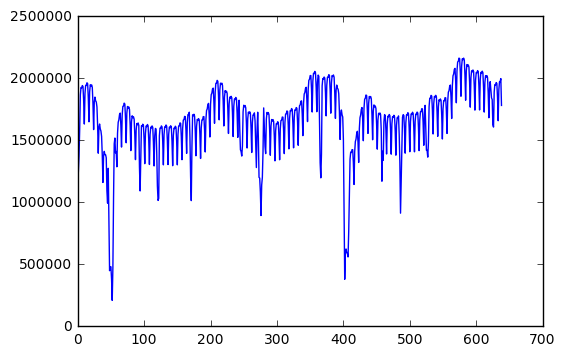

In [18]:
plt.plot(forecast_All2)